# Training a CNN for a real-world Image Classification Task

This is an example of defining and training a CNN to deal with a real-world image classification. These are images taken by numerous amatuer photgraphers, in multiple cameras and lightening conditions. 

We will show:
1. How a relatively shallow CNN with 5 convolution layers and about 1 million parameters can defined in a dozen lines of code, and trained for 30m on a CPU (or ~3m on a GPU), to achieve reasnoble accuracy for classifying real-world images (74.3%). 
2. We will see, that getting to good results on relatively small training data (1000 samples per class in a binary classification task) can be greatly improved by introducing **data augmentation** and **dropout**. This will set the accuracy at 81.7%. This is just the beginning - training a larger network with more data could easily increase the accuracy. Fine-tunning a large CNN pre-trained on other images, and fine-tuned on the same small dataset - is an excellent way to increase the accuracy further. 
3. We will use the `dataset` API, that was introduced in a previous notebook. 

Here we are following Chollet Deep Learning with Python, chapter 8. The code was adapted for its Github notebook based on the Apache 2.0 license. 


In [ ]:
# Imports for file operations and random selection

# import os
# import random
# import shutil
# from pathlib import Path

The below code block was to copy the random 5000 images of cats and dogs from the main 20K dataset. This code snippet ensures train, test and validation folders have same number of dogs and cat images. The tain, test, validation sets are split in the ratio 0.7,0.15,0.15 respectively. The code block is commented because this step has already completed and we are not doing it again to ensure consistancy in the input data. Also I have not included the 20K images folder in git because we have already picked the 5K images needed for this assignment.

In [ ]:
# # Config
# source_dir = Path("data/full_dataset/train/train")
# output_base = Path("data/kaggle_dogs_vs_cats_small")
# num_per_class = 2500  # total cats + dogs = 5000
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15
# random.seed(42)

# # Calculate split sizes per class
# train_count = int(train_ratio * num_per_class)
# val_count = int(val_ratio * num_per_class)
# test_count = num_per_class - train_count - val_count  # to avoid rounding error

# # Create folders
# for split in ['train', 'validation', 'test']:
#     (output_base / split).mkdir(parents=True, exist_ok=True)

# # Get and shuffle image lists
# cat_images = sorted(source_dir.glob("cat.*.jpg"))
# dog_images = sorted(source_dir.glob("dog.*.jpg"))
# random.shuffle(cat_images)
# random.shuffle(dog_images)

# # Take only 2500 from each class
# cat_images = cat_images[:num_per_class]
# dog_images = dog_images[:num_per_class]

# # Function to copy exact number of files per split
# def copy_split(images, split_sizes, prefix):
#     train_split = images[:split_sizes['train']]
#     val_split = images[split_sizes['train']:split_sizes['train'] + split_sizes['val']]
#     test_split = images[split_sizes['train'] + split_sizes['val']:]

#     for split_name, files in zip(['train', 'validation', 'test'], [train_split, val_split, test_split]):
#         for f in files:
#             dest = output_base / split_name / f.name
#             shutil.copy(f, dest)

# # Define exact sizes
# split_sizes = {
#     'train': train_count,
#     'val': val_count,
#     'test': test_count
# }

# # Copy balanced splits
# copy_split(cat_images, split_sizes, "cat")
# copy_split(dog_images, split_sizes, "dog")

# # Print verification
# for split in ['train', 'validation', 'test']:
#     files = os.listdir(output_base / split)
#     cat_count = len([f for f in files if f.startswith("cat")])
#     dog_count = len([f for f in files if f.startswith("dog")])
#     print(f"{split.capitalize()}: {cat_count} cats, {dog_count} dogs, total: {len(files)}")

# print("Equal number of cats and dogs in each split.")


Train: 1750 cats, 1750 dogs, total: 3500
Validation: 375 cats, 375 dogs, total: 750
Test: 375 cats, 375 dogs, total: 750
Equal number of cats and dogs in each split.


I have use anaconda to create the virtual environment this time. All the requirements for the anaconda environment can be found in 'requirements.yml' which is the standard requirement file to create a conda environment.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.build_info)

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [9]:
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.build_info)

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [10]:
# List all physical GPU devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Optionally set memory growth to prevent TensorFlow from grabbing all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU is available: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ RuntimeError while setting up GPU: {e}")
else:
    print("❌ No GPU found. Using CPU.")

✅ GPU is available: /physical_device:GPU:0


Since I have a NVDIA GPU, the training is done using the GPU.

Load the data into three sets: 

In [16]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('data/kaggle_dogs_vs_cats_small')

In [18]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3500 files belonging to 2 classes.
Found 750 files belonging to 2 classes.
Found 750 files belonging to 2 classes.


### Definning the model

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [21]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

Note that running the training on a CPU could take about 30 minutes.

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
110/110 [==============================] - 13s 51ms/step - loss: 0.7281 - accuracy: 0.5326 - val_loss: 0.6788 - val_accuracy: 0.5747
Epoch 2/30
110/110 [==============================] - 5s 45ms/step - loss: 0.7143 - accuracy: 0.5531 - val_loss: 0.6420 - val_accuracy: 0.6613
Epoch 3/30
110/110 [==============================] - 5s 46ms/step - loss: 0.6239 - accuracy: 0.6589 - val_loss: 0.5956 - val_accuracy: 0.6867
Epoch 4/30
110/110 [==============================] - 5s 47ms/step - loss: 0.5839 - accuracy: 0.6991 - val_loss: 0.5441 - val_accuracy: 0.7347
Epoch 5/30
110/110 [==============================] - 5s 47ms/step - loss: 0.5416 - accuracy: 0.7389 - val_loss: 0.7214 - val_accuracy: 0.6747
Epoch 6/30
110/110 [==============================] - 5s 47ms/step - loss: 0.4974 - accuracy: 0.7546 - val_loss: 0.5140 - val_accuracy: 0.7493
Epoch 7/30
110/110 [==============================] - 5s 47ms/step - loss: 0.4586 - accuracy: 0.7894 - val_loss: 0.4889 - val_accuracy: 0.768

**Displaying curves of loss and accuracy during training**

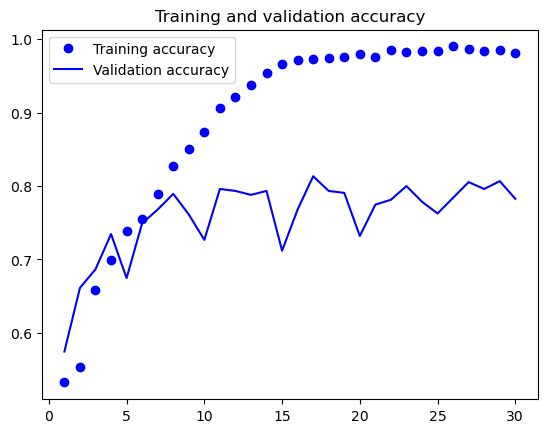

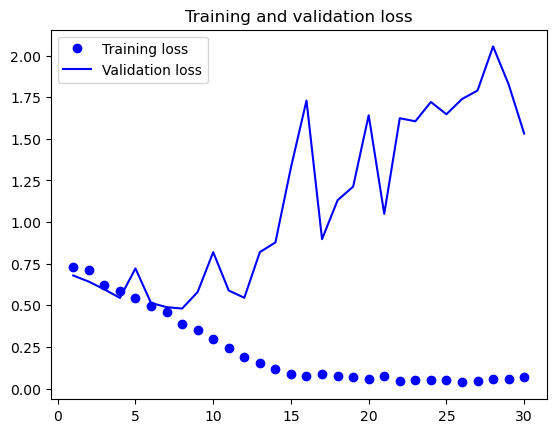

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting is evident, around epoch 12. 

**Evaluating the model on the test set**

In [24]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 1s 23ms/step - loss: 0.5561 - accuracy: 0.7453
Test accuracy: 0.745


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

See the Keras documentation to see what each method does. Notice that the augmentations are defined as a sequential model.

**Displaying some randomly augmented training images**

Here we use the `data_augmentation` model that we defined above, and pass the same image nine times.
Can you identify the three augmenting effects? 

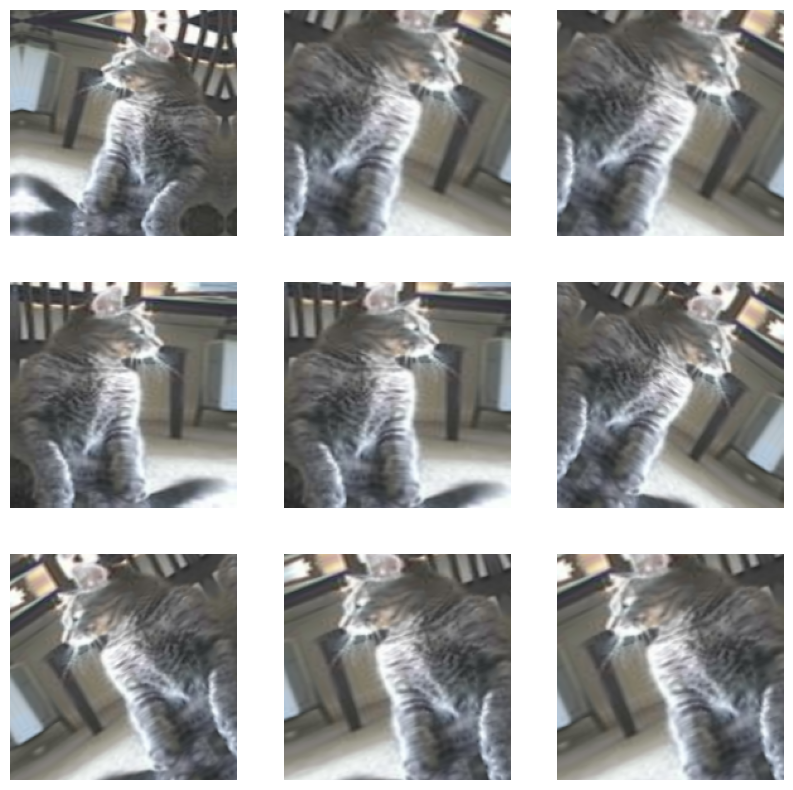

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

Our new model includes two changes compared to the previous one:
1. data augmentation as the first step
2. a dropout layer just before the last layer for regularization

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

Notice that the number of parameters is the same as the previous model.

**Training the regularized convnet**

Here we train for 100 epochs, compared to 30 before. Since the previous model overfitted after about 12 epoches, this discrepency still allows one to reasonably compare the performance of the two models. 

Note: running the training on a CPU will take about 2 hours.

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
110/110 [==============================] - 20s 157ms/step - loss: 0.7548 - accuracy: 0.5169 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 2/100
110/110 [==============================] - 24s 214ms/step - loss: 0.6949 - accuracy: 0.5429 - val_loss: 0.6799 - val_accuracy: 0.5907
Epoch 3/100
110/110 [==============================] - 18s 163ms/step - loss: 0.6847 - accuracy: 0.5863 - val_loss: 0.7138 - val_accuracy: 0.5093
Epoch 4/100
110/110 [==============================] - 19s 172ms/step - loss: 0.6525 - accuracy: 0.6351 - val_loss: 0.6429 - val_accuracy: 0.6093
Epoch 5/100
110/110 [==============================] - 21s 194ms/step - loss: 0.6237 - accuracy: 0.6574 - val_loss: 0.5432 - val_accuracy: 0.7147
Epoch 6/100
110/110 [==============================] - 34s 307ms/step - loss: 0.6048 - accuracy: 0.6811 - val_loss: 0.6302 - val_accuracy: 0.6467
Epoch 7/100
110/110 [==============================] - 24s 212ms/step - loss: 0.5901 - accuracy: 0.6937 - val_loss: 0.6337 -

**Evaluating the model on the test set**

Note the data augmentation and dropout are applied only during training, not during inference. 

In [30]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 1s 22ms/step - loss: 0.4367 - accuracy: 0.8320
Test accuracy: 0.832


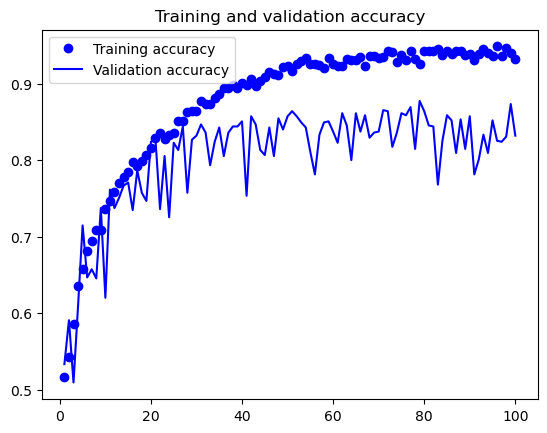

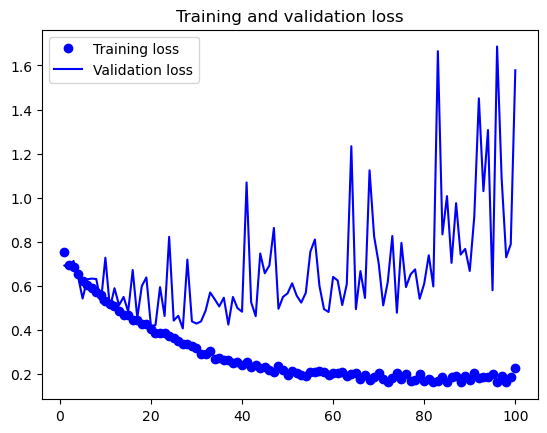

In [31]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Here an overfit is much less evident. Based on the validation accuracy it might have been reached only towards the last few epoches. Though the vaidation loss, while noisy, starts to increase after the 50th epoch or so. 